In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
import glob as gb
import seaborn as sns
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
IMG_SIZE = 128
SEED = 1000
BATCH_SIZE = 32

TRAIN_DIR = 'F:/CVPR/Alzheimers-ADNI/train'
TEST_DIR =  'F:/CVPR/Alzheimers-ADNI//test'

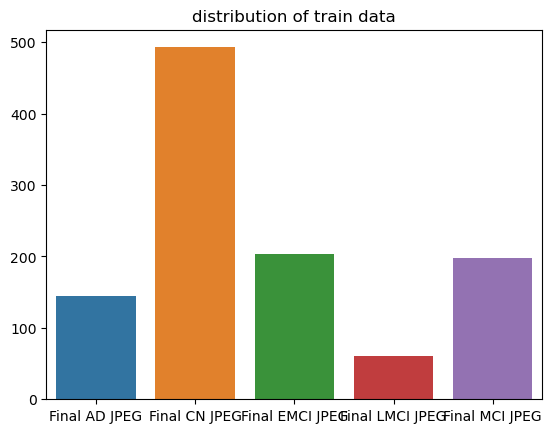

1101


In [6]:
categories = []
class_count = []
train_exm = 0
for f in os.listdir(TRAIN_DIR):
    files = gb.glob(pathname=str(TRAIN_DIR  + '//' + f + '/*.jpg'))
    categories.append(f)
    class_count.append(len(files))
    train_exm += len(files)

sns.barplot(x=categories, y=class_count).set_title("distribution of train data")

plt.show()
print(train_exm)

In [7]:
train_gen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    validation_split = 0.2,
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
)

test_gen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
)

In [8]:
train_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    subset = 'training',
    seed = SEED
)
valid_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    subset = 'validation',
    seed = SEED
)
test_batch = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    seed = SEED
)

Found 883 images belonging to 5 classes.
Found 218 images belonging to 5 classes.
Found 195 images belonging to 5 classes.


In [9]:
img_shape = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False,  weights='imagenet')
print(base_model.summary())

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 6d6bbae143d832006294945121d1f1fc so we will re-download the data.
58889256/58889256 [==============================] - 62s 1us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856   

In [10]:
for layer in base_model.layers:
    layer.trainable = False

In [11]:
input = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
x = base_model(input, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(input, output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                             

In [12]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= tf.keras.losses.sparse_categorical_crossentropy,
    metrics= ['accuracy']
)

In [13]:
h = model.fit(
    train_batch,
    steps_per_epoch = 883 // BATCH_SIZE,
    validation_data = valid_batch,
    validation_steps = 218 // BATCH_SIZE,
    epochs = 10
)

Epoch 1/10
27/27 [==============================] - 72s 3s/step - loss: 2.8700 - accuracy: 0.3302 - val_loss: 1.5455 - val_accuracy: 0.4375
Epoch 2/10
27/27 [==============================] - 66s 2s/step - loss: 1.6219 - accuracy: 0.3643 - val_loss: 1.3954 - val_accuracy: 0.4271
Epoch 3/10
27/27 [==============================] - 66s 2s/step - loss: 1.4654 - accuracy: 0.4183 - val_loss: 1.3570 - val_accuracy: 0.4844
Epoch 4/10
27/27 [==============================] - 65s 2s/step - loss: 1.3926 - accuracy: 0.4289 - val_loss: 1.4147 - val_accuracy: 0.4115
Epoch 5/10
27/27 [==============================] - 65s 2s/step - loss: 1.4096 - accuracy: 0.4148 - val_loss: 1.4237 - val_accuracy: 0.4583
Epoch 6/10
27/27 [==============================] - 65s 2s/step - loss: 1.3863 - accuracy: 0.4348 - val_loss: 1.3879 - val_accuracy: 0.4792
Epoch 7/10
27/27 [==============================] - 65s 2s/step - loss: 1.3548 - accuracy: 0.4630 - val_loss: 1.3755 - val_accuracy: 0.4635
Epoch 8/10
27/27 [==

In [14]:
for layer in base_model.layers[-8:]:
    layer.trainable = True

In [15]:
print(f"VGG16- number of layers: {len(base_model.layers)}")
for layer in base_model.layers:
    print(f"{layer.name} trainable? {layer.trainable}")

VGG16- number of layers: 19
input_1 trainable? False
block1_conv1 trainable? False
block1_conv2 trainable? False
block1_pool trainable? False
block2_conv1 trainable? False
block2_conv2 trainable? False
block2_pool trainable? False
block3_conv1 trainable? False
block3_conv2 trainable? False
block3_conv3 trainable? False
block3_pool trainable? False
block4_conv1 trainable? True
block4_conv2 trainable? True
block4_conv3 trainable? True
block4_pool trainable? True
block5_conv1 trainable? True
block5_conv2 trainable? True
block5_conv3 trainable? True
block5_pool trainable? True


In [16]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= tf.keras.losses.sparse_categorical_crossentropy,
    metrics= ['accuracy']
)

In [17]:
h1 = model.fit(
    train_batch,
    steps_per_epoch = 883 // BATCH_SIZE,
    validation_data = valid_batch,
    validation_steps = 218 // BATCH_SIZE,
    epochs = 10
)

Epoch 1/10
27/27 [==============================] - 119s 4s/step - loss: 5.9965 - accuracy: 0.3502 - val_loss: 1.4375 - val_accuracy: 0.4531
Epoch 2/10
27/27 [==============================] - 127s 5s/step - loss: 1.4989 - accuracy: 0.4172 - val_loss: 1.4483 - val_accuracy: 0.4323
Epoch 3/10
27/27 [==============================] - 119s 4s/step - loss: 1.4569 - accuracy: 0.4454 - val_loss: 1.4501 - val_accuracy: 0.4427
Epoch 4/10
27/27 [==============================] - 120s 4s/step - loss: 1.7441 - accuracy: 0.4031 - val_loss: 1.4730 - val_accuracy: 0.4427
Epoch 5/10
27/27 [==============================] - 120s 4s/step - loss: 1.4806 - accuracy: 0.4207 - val_loss: 1.4834 - val_accuracy: 0.4479
Epoch 6/10
27/27 [==============================] - 121s 4s/step - loss: 1.4296 - accuracy: 0.4489 - val_loss: 1.4707 - val_accuracy: 0.4271
Epoch 7/10
27/27 [==============================] - 117s 4s/step - loss: 1.4397 - accuracy: 0.4524 - val_loss: 1.4140 - val_accuracy: 0.4583
Epoch 8/10
27

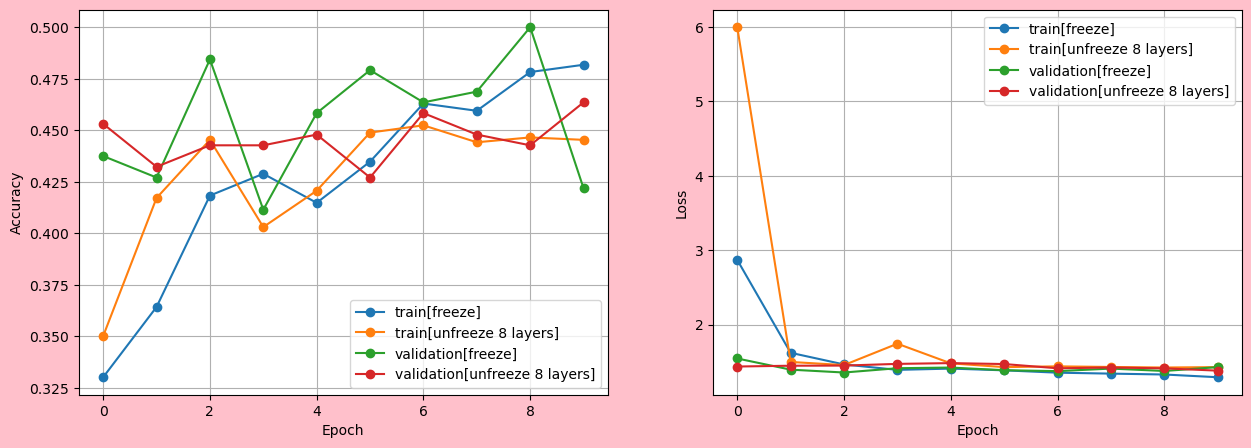

In [18]:
plt.figure(figsize=(15,5), facecolor='pink')
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train[freeze]')
plt.plot(h1.history['accuracy'], 'o-', label='train[unfreeze 8 layers]')

plt.plot(h.history['val_accuracy'], 'o-', label = 'validation[freeze]')
plt.plot(h1.history['val_accuracy'], 'o-', label = 'validation[unfreeze 8 layers]')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train[freeze]')
plt.plot(h1.history['loss'], 'o-', label='train[unfreeze 8 layers]')

plt.plot(h.history['val_loss'], 'o-', label='validation[freeze]')
plt.plot(h1.history['val_loss'], 'o-', label='validation[unfreeze 8 layers]')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()